### 기상 데이터 기반 LSTM 및 랜덤 포레스트를 활용한 미세먼지 농도 예측 모델 개발
#### A분반_G팀

#### Data
* train.csv
* test.csv

#### Code
* train.ipynb

#### 작업 환경
* Ubuntu Server 22.04
* R5 5600 
* DDR4 32GB

#### 실행 테스트 환경
* Windows 11 
* R7 4800H
* DDR4 32GB



In [1]:
! pip install -u scikit-learn
! pip install tensorflow
! pip install seaborn
! pip install ace_tools


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


In [2]:
# 그래프에서 한글이 깨지지 않도록 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# # Windows의 경우 설치된 폰트 중 하나 사용 (예: 'Malgun Gothic')
# plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'NanumGothic'
# plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# linux 의 경우 폰트 경로 설정

path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

# **1. 데이터 불러오기**

In [3]:
import os

os.chdir('/home/shinhs/Team_G')

print(os.getcwd())

/home/shinhs/Team_G


In [4]:
import pandas as pd


train = pd.read_csv('./train.csv')

test = pd.read_csv('./test.csv')

train_df = pd.DataFrame(train)

test_df = pd.DataFrame(test)

print("train")
print(train_df.head())
print("test")
print(test_df.head())


train
              일자   기온  풍속(m/s)  풍향(16방위)  습도(%)  증기압(hPa)  현지기압(hPa)  일조(hr)  \
0  2020-01-01-00 -6.5      0.0       0.0     38       1.4     1022.6     NaN   
1  2020-01-01-01 -5.9      1.7      50.0     40       1.6     1021.8     NaN   
2  2020-01-01-02 -5.7      0.1       0.0     42       1.7     1021.6     NaN   
3  2020-01-01-03 -5.6      0.0       0.0     46       1.8     1021.5     NaN   
4  2020-01-01-04 -5.4      0.0       0.0     50       2.0     1021.6     NaN   

   일사(MJ/m2)  지면온도(°C)    오 존  이산화질소 일산화탄소  아황산가스 PM10 PM2.5  
0        NaN      -2.8    NaN    NaN   NaN    NaN  NaN   NaN  
1        NaN      -2.4  0.002  0.036   0.6  0.003   30    16  
2        NaN      -2.4  0.001  0.036   0.6  0.003   34    18  
3        NaN      -2.7  0.002  0.038   0.8  0.003   35    22  
4        NaN      -2.5  0.001  0.034   0.6  0.003   34    19  
test
              일자   기온  풍속(m/s)  풍향(16방위)  습도(%)  증기압(hPa)  현지기압(hPa)  일조(hr)  \
0  2024-01-01-00  0.6      1.9      20.0     97   

In [5]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   일자         35064 non-null  object 
 1   기온         35063 non-null  float64
 2   풍속(m/s)    35025 non-null  float64
 3   풍향(16방위)   35025 non-null  float64
 4   습도(%)      35064 non-null  int64  
 5   증기압(hPa)   35062 non-null  float64
 6   현지기압(hPa)  35051 non-null  float64
 7   일조(hr)     19165 non-null  float64
 8   일사(MJ/m2)  19165 non-null  float64
 9   지면온도(°C)   35049 non-null  float64
 10  오 존        34641 non-null  object 
 11  이산화질소      33461 non-null  object 
 12  일산화탄소      34485 non-null  object 
 13  아황산가스      34604 non-null  object 
 14  PM10       34500 non-null  object 
 15  PM2.5      34558 non-null  object 
dtypes: float64(8), int64(1), object(7)
memory usage: 4.3+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   일자         8784 non-null   object 
 1   기온         8784 non-null   float64
 2   풍속(m/s)    8753 non-null   float64
 3   풍향(16방위)   8753 non-null   float64
 4   습도(%)      8784 non-null   int64  
 5   증기압(hPa)   8784 non-null   float64
 6   현지기압(hPa)  8784 non-null   float64
 7   일조(hr)     4784 non-null   float64
 8   일사(MJ/m2)  4785 non-null   float64
 9   지면온도(°C)   8784 non-null   float64
 10  오 존        8610 non-null   object 
 11  이산화질소      8652 non-null   object 
 12  일산화탄소      8650 non-null   object 
 13  아황산가스      8643 non-null   object 
 14  PM10       8629 non-null   object 
 15  PM2.5      8583 non-null   object 
dtypes: float64(8), int64(1), object(7)
memory usage: 1.1+ MB


# **2. 데이터 전처리**

In [7]:

train_df['일자'] = pd.to_datetime(train_df['일자'], format='%Y-%m-%d-%H')


train_df['년']   = train_df['일자'].dt.year
train_df['월']   = train_df['일자'].dt.month
train_df['일']   = train_df['일자'].dt.day
train_df['시간'] = train_df['일자'].dt.hour


train_df.head()




,일자,기온,풍속(m/s),풍향(16방위),습도(%),증기압(hPa),현지기압(hPa),일조(hr),일사(MJ/m2),지면온도(°C),오 존,이산화질소,일산화탄소,아황산가스,PM10,PM2.5,년,월,일,시간
0,2020-01-01 00:00:00,-6.5,0.0,0.0,38,1.4,1022.6,NaN,NaN,-2.8,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1,0
1,2020-01-01 01:00:00,-5.9,1.7,50.0,40,1.6,1021.8,NaN,NaN,-2.4,0.002,0.036,0.6,0.003,30,16,2020,1,1,1
2,2020-01-01 02:00:00,-5.7,0.1,0.0,42,1.7,1021.6,NaN,NaN,-2.4,0.001,0.036,0.6,0.003,34,18,2020,1,1,2
3,2020-01-01 03:00:00,-5.6,0.0,0.0,46,1.8,1021.5,NaN,NaN,-2.7,0.002,0.038,0.8,0.003,35,22,2020,1,1,3
4,2020-01-01 04:00:00,-5.4,0.0,0.0,50,2.0,1021.6,NaN,NaN,-2.5,0.001,0.034,0.6,0.003,34,19,2020,1,1,4


In [8]:
test_df['일자'] = pd.to_datetime(test_df['일자'], format='%Y-%m-%d-%H')


test_df['년']   = test_df['일자'].dt.year
test_df['월']   = test_df['일자'].dt.month
test_df['일']   = test_df['일자'].dt.day
test_df['시간'] = test_df['일자'].dt.hour


test_df.head()

,일자,기온,풍속(m/s),풍향(16방위),습도(%),증기압(hPa),현지기압(hPa),일조(hr),일사(MJ/m2),지면온도(°C),오 존,이산화질소,일산화탄소,아황산가스,PM10,PM2.5,년,월,일,시간
0,2024-01-01 00:00:00,0.6,1.9,20.0,97,6.2,1015.4,NaN,NaN,-0.2,0.0058,0.0344,0.75,0.0035,30,22,2024,1,1,0
1,2024-01-01 01:00:00,0.5,2.2,50.0,97,6.1,1015.6,NaN,NaN,-0.2,0.0047,0.034,0.8,0.0033,32,21,2024,1,1,1
2,2024-01-01 02:00:00,0.4,0.4,0.0,98,6.2,1016.2,NaN,NaN,-0.3,0.0022,0.0359,0.87,0.0033,35,22,2024,1,1,2
3,2024-01-01 03:00:00,-0.1,1.7,20.0,98,6.0,1016.6,NaN,NaN,-0.3,0.0018,0.0378,0.91,0.0034,35,24,2024,1,1,3
4,2024-01-01 04:00:00,-0.2,2.2,20.0,98,5.9,1016.8,NaN,NaN,-0.3,0.0035,0.0377,0.82,0.0032,37,26,2024,1,1,4


In [9]:
# 각 열에 존재하는 결측값의 개수를 계산
missing_values = train_df.isnull().sum()

# 전체 행 수를 기준으로 결측값이 차지하는 비율(%)을 계산
total_rows = len(train_df)
missing_percentage = (missing_values / total_rows) * 100

# 각 열별 결측값 비율을 소수점 둘째 자리까지 반올림하여 출력
print("\n각 열의 결측값 비율 (%):")
print(missing_percentage.round(2))


각 열의 결측값 비율 (%):
일자            0.00
기온            0.00
풍속(m/s)       0.11
풍향(16방위)      0.11
습도(%)         0.00
증기압(hPa)      0.01
현지기압(hPa)     0.04
일조(hr)       45.34
일사(MJ/m2)    45.34
지면온도(°C)      0.04
오 존           1.21
이산화질소         4.57
일산화탄소         1.65
아황산가스         1.31
PM10          1.61
PM2.5         1.44
년             0.00
월             0.00
일             0.00
시간            0.00
dtype: float64


In [10]:
print(train_df[['시간', '일조(hr)', '일사(MJ/m2)']].head(24), '\n', test_df[['시간', '일조(hr)', '일사(MJ/m2)']].head(24))


    시간  일조(hr)  일사(MJ/m2)
0    0     NaN        NaN
1    1     NaN        NaN
2    2     NaN        NaN
3    3     NaN        NaN
4    4     NaN        NaN
5    5     NaN        NaN
6    6     NaN        NaN
7    7     NaN        NaN
8    8     0.0       0.00
9    9     0.0       0.04
10  10     0.0       0.17
11  11     0.0       0.41
12  12     0.5       1.00
13  13     0.0       0.93
14  14     0.0       0.89
15  15     0.3       0.68
16  16     0.0       0.32
17  17     0.0       0.09
18  18     0.0       0.00
19  19     NaN        NaN
20  20     NaN        NaN
21  21     NaN        NaN
22  22     NaN        NaN
23  23     NaN        NaN 
     시간  일조(hr)  일사(MJ/m2)
0    0     NaN        NaN
1    1     NaN        NaN
2    2     NaN        NaN
3    3     NaN        NaN
4    4     NaN        NaN
5    5     NaN        NaN
6    6     NaN        NaN
7    7     NaN        NaN
8    8     0.0       0.00
9    9     0.5       0.27
10  10     1.0       0.82
11  11     1.0       1.36
12  12    

In [11]:
# '일조(hr)', '일사(MJ/m2)' 열 결측치 0 으로 채우기
train_df['일조(hr)'] = train_df['일조(hr)'].fillna(0)
train_df['일사(MJ/m2)'] = train['일사(MJ/m2)'].fillna(0)

# 처리 후 결측값 개수 확인
missing_after = train_df.isnull().sum()
print("결측값 처리 이후 각 열의 결측값 개수:")
print(missing_after)

train_df.head()


결측값 처리 이후 각 열의 결측값 개수:
일자              0
기온              1
풍속(m/s)        39
풍향(16방위)       39
습도(%)           0
증기압(hPa)        2
현지기압(hPa)      13
일조(hr)          0
일사(MJ/m2)       0
지면온도(°C)       15
오 존           423
이산화질소        1603
일산화탄소         579
아황산가스         460
PM10          564
PM2.5         506
년               0
월               0
일               0
시간              0
dtype: int64


,일자,기온,풍속(m/s),풍향(16방위),습도(%),증기압(hPa),현지기압(hPa),일조(hr),일사(MJ/m2),지면온도(°C),오 존,이산화질소,일산화탄소,아황산가스,PM10,PM2.5,년,월,일,시간
0,2020-01-01 00:00:00,-6.5,0.0,0.0,38,1.4,1022.6,0.0,0.0,-2.8,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1,0
1,2020-01-01 01:00:00,-5.9,1.7,50.0,40,1.6,1021.8,0.0,0.0,-2.4,0.002,0.036,0.6,0.003,30,16,2020,1,1,1
2,2020-01-01 02:00:00,-5.7,0.1,0.0,42,1.7,1021.6,0.0,0.0,-2.4,0.001,0.036,0.6,0.003,34,18,2020,1,1,2
3,2020-01-01 03:00:00,-5.6,0.0,0.0,46,1.8,1021.5,0.0,0.0,-2.7,0.002,0.038,0.8,0.003,35,22,2020,1,1,3
4,2020-01-01 04:00:00,-5.4,0.0,0.0,50,2.0,1021.6,0.0,0.0,-2.5,0.001,0.034,0.6,0.003,34,19,2020,1,1,4


In [12]:
# '일조(hr)', '일사(MJ/m2)' 열 결측치 0 으로 채우기기
test_df['일조(hr)'] = test_df['일조(hr)'].fillna(0)
test_df['일사(MJ/m2)'] = test['일사(MJ/m2)'].fillna(0)

test_df.head()

,일자,기온,풍속(m/s),풍향(16방위),습도(%),증기압(hPa),현지기압(hPa),일조(hr),일사(MJ/m2),지면온도(°C),오 존,이산화질소,일산화탄소,아황산가스,PM10,PM2.5,년,월,일,시간
0,2024-01-01 00:00:00,0.6,1.9,20.0,97,6.2,1015.4,0.0,0.0,-0.2,0.0058,0.0344,0.75,0.0035,30,22,2024,1,1,0
1,2024-01-01 01:00:00,0.5,2.2,50.0,97,6.1,1015.6,0.0,0.0,-0.2,0.0047,0.034,0.8,0.0033,32,21,2024,1,1,1
2,2024-01-01 02:00:00,0.4,0.4,0.0,98,6.2,1016.2,0.0,0.0,-0.3,0.0022,0.0359,0.87,0.0033,35,22,2024,1,1,2
3,2024-01-01 03:00:00,-0.1,1.7,20.0,98,6.0,1016.6,0.0,0.0,-0.3,0.0018,0.0378,0.91,0.0034,35,24,2024,1,1,3
4,2024-01-01 04:00:00,-0.2,2.2,20.0,98,5.9,1016.8,0.0,0.0,-0.3,0.0035,0.0377,0.82,0.0032,37,26,2024,1,1,4


In [13]:
train_obj_cols = [col for col in train_df.columns if train_df[col].dtype == 'object']
test_obj_cols = [col for col in test_df.columns if test_df[col].dtype == 'object']

for col in train_obj_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

for col in test_obj_cols:
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

In [14]:
train_df = train_df.dropna(axis=0, how='any')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32867 entries, 1 to 35063
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   일자         32867 non-null  datetime64[ns]
 1   기온         32867 non-null  float64       
 2   풍속(m/s)    32867 non-null  float64       
 3   풍향(16방위)   32867 non-null  float64       
 4   습도(%)      32867 non-null  int64         
 5   증기압(hPa)   32867 non-null  float64       
 6   현지기압(hPa)  32867 non-null  float64       
 7   일조(hr)     32867 non-null  float64       
 8   일사(MJ/m2)  32867 non-null  float64       
 9   지면온도(°C)   32867 non-null  float64       
 10  오 존        32867 non-null  float64       
 11  이산화질소      32867 non-null  float64       
 12  일산화탄소      32867 non-null  float64       
 13  아황산가스      32867 non-null  float64       
 14  PM10       32867 non-null  float64       
 15  PM2.5      32867 non-null  float64       
 16  년          32867 non-null  int32         
 17

In [15]:
test_df = test_df.dropna(axis=0, how='any')

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8476 entries, 0 to 8783
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   일자         8476 non-null   datetime64[ns]
 1   기온         8476 non-null   float64       
 2   풍속(m/s)    8476 non-null   float64       
 3   풍향(16방위)   8476 non-null   float64       
 4   습도(%)      8476 non-null   int64         
 5   증기압(hPa)   8476 non-null   float64       
 6   현지기압(hPa)  8476 non-null   float64       
 7   일조(hr)     8476 non-null   float64       
 8   일사(MJ/m2)  8476 non-null   float64       
 9   지면온도(°C)   8476 non-null   float64       
 10  오 존        8476 non-null   float64       
 11  이산화질소      8476 non-null   float64       
 12  일산화탄소      8476 non-null   float64       
 13  아황산가스      8476 non-null   float64       
 14  PM10       8476 non-null   float64       
 15  PM2.5      8476 non-null   float64       
 16  년          8476 non-null   int32         
 17  

In [16]:
train_df = train_df.sort_values(by='일자').reset_index(drop=True)
test_df = test_df.sort_values(by='일자').reset_index(drop=True)

# **3. 모델링 : LSTM**

2025-05-31 12:20:54.490364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748694054.501262   56799 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748694054.504587   56799 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748694054.513862   56799 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748694054.513874   56799 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748694054.513875   56799 computation_placer.cc:177] computation placer alr

Epoch 1/50


W0000 00:00:1748694055.677766   56799 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0114 - val_loss: 0.0056
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0030 - val_loss: 0.0064
Epoch 7/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0027 - val_loss: 0.0064
Epoch 8/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 9/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 10/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 11/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0022 - val_loss: 0.0045
Epoch 12/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/ste

/tmp/ipykernel_56799/840632631.py:125: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_56799/840632631.py:125: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_56799/840632631.py:125: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_56799/840632631.py:125: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/shinhs/miniconda3/envs/vargpt/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shinhs/miniconda3/envs/vargpt/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.

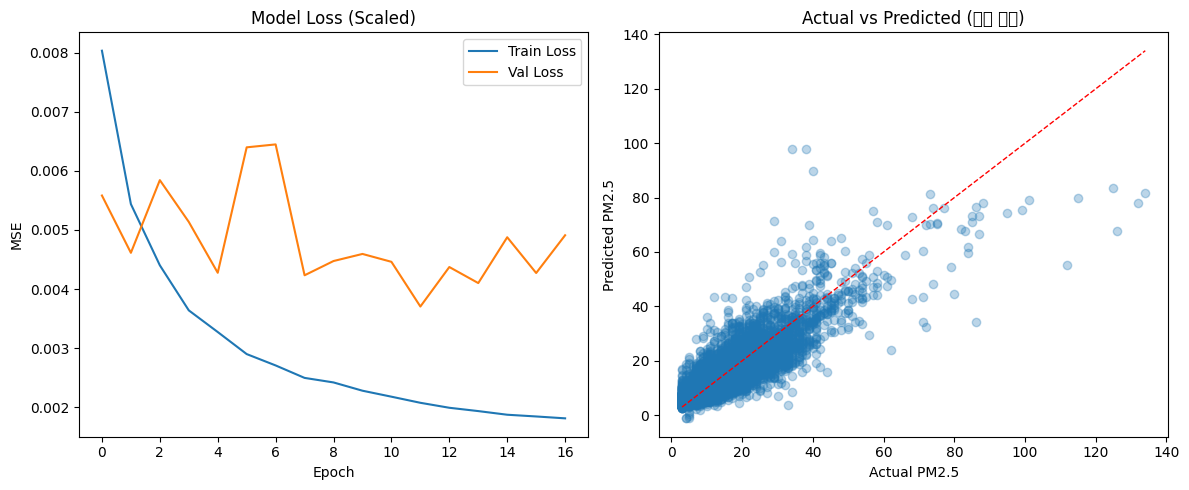

In [17]:
# LSTM 모델용 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# 예측에 사용할 특징(feature)과 목표(target) 변수 지정
features = [col for col in train_df.columns if col not in ['PM2.5', '일자']]

target   = 'PM2.5'


values = train_df[features + [target]].values


seq_length = 24
split_idx = int(len(values) * 0.8)
train_vals = values[:split_idx]
test_vals  = values[split_idx - seq_length:]  # 시퀀스 overlap 고려


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
test_scaled  = scaler.transform(test_vals)


# 시퀀스 데이터 생성 함수 정의
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, seq_length)
X_test,  y_test  = create_sequences(test_scaled, seq_length)


model = Sequential([
    Input(shape=(seq_length, len(features))),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


val_split_idx = int(len(X_train) * 0.8)
X_trn, y_trn = X_train[:val_split_idx], y_train[:val_split_idx]
X_val, y_val = X_train[val_split_idx:], y_train[val_split_idx:]



early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_trn, y_trn,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


scaled_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Scaled Test MSE: {scaled_loss:.4f}")

# 스케일된 예측값 → 원본 단위로 역변환
y_pred_scaled = model.predict(X_test)

# (n_seq, 1) → (n_seq, n_features+1)의 더미 배열 만들어서 역변환
dummy_test  = np.zeros((len(y_test), len(features) + 1))
dummy_pred  = np.zeros((len(y_pred_scaled), len(features) + 1))
dummy_test[:, -1] = y_test
dummy_pred[:, -1] = y_pred_scaled.reshape(-1)

orig_y_test = scaler.inverse_transform(dummy_test)[:, -1]
orig_y_pred = scaler.inverse_transform(dummy_pred)[:, -1]

# ---------------------------
# 원본 단위 MSE 계산 및 출력
# ---------------------------
orig_mse = mean_squared_error(orig_y_test, orig_y_pred)
print(f"Original Test MSE: {orig_mse:.4f}")



y_pred_scaled = model.predict(X_test)

# 각각 (n_seq, 1) 형태 → (n_seq, n_features+1) 모양의 더미 배열을 만들어서 역변환
dummy_test  = np.zeros((len(y_test), len(features) + 1))
dummy_pred  = np.zeros((len(y_pred_scaled), len(features) + 1))
dummy_test[:, -1] = y_test
dummy_pred[:, -1] = y_pred_scaled.reshape(-1)

orig_y_test = scaler.inverse_transform(dummy_test)[:, -1]
orig_y_pred = scaler.inverse_transform(dummy_pred)[:, -1]

# 10) 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Scaled)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(orig_y_test, orig_y_pred, alpha=0.3)
_min, _max = orig_y_test.min(), orig_y_test.max()
plt.plot([_min, _max], [_min, _max], 'r--', linewidth=1)
plt.title('Actual vs Predicted (원본 단위)')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')

plt.tight_layout()
plt.show()


# **4. 모델링 : Random Forest**

랜덤 포레스트 모델 학습 중...
1.41초 만에 학습 완료

모델 평가 결과 (원본 단위):
Random Forest - MSE: 29.679, R²: 0.766


/tmp/ipykernel_56799/718915503.py:81: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_56799/718915503.py:81: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_56799/718915503.py:81: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_56799/718915503.py:81: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_56799/718915503.py:81: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_56799/718915503.py:81: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_56799/718915503.py:81: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_la

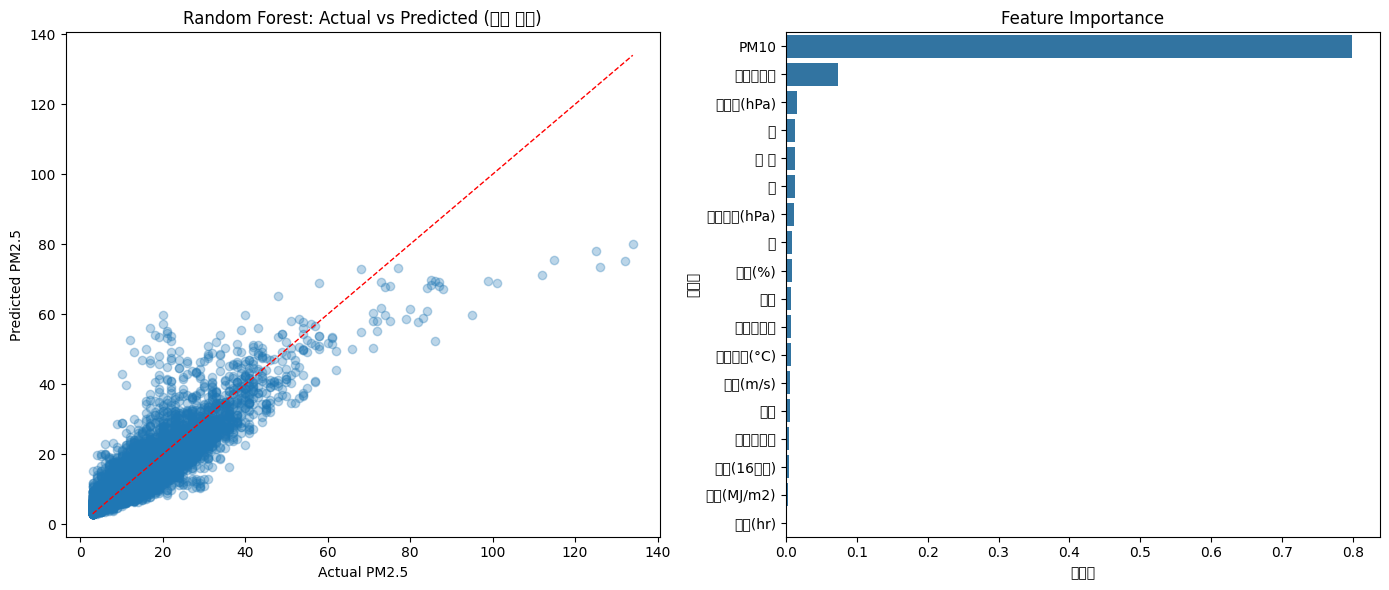

In [21]:
# 랜덤 포레스트에 필요한 라이브러리 불러오기
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
import seaborn as sns

X_data = train_df[features].values
y_data = train_df[target].values

# (A) time-based split 
split_idx = int(len(X_data) * 0.8)
X_train_rf = X_data[:split_idx]
y_train_rf = y_data[:split_idx]
X_test_rf  = X_data[split_idx:]
y_test_rf  = y_data[split_idx:]


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_rf)
X_test_scaled  = scaler_X.transform(X_test_rf)

y_train_scaled = scaler_y.fit_transform(y_train_rf.reshape(-1, 1)).ravel()
y_test_scaled  = scaler_y.transform(y_test_rf.reshape(-1, 1)).ravel()
print("랜덤 포레스트 모델 학습 중...")
start_time = time.time()

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train_scaled)

print(f"{time.time() - start_time:.2f}초 만에 학습 완료")


y_pred_scaled = rf_model.predict(X_test_scaled)

# 스케일 역변환 (n_test, 1) 형태로 reshape 후 inverse_transform
orig_y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))[:, 0]
orig_y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))[:, 0]



mse_rf_orig = mean_squared_error(orig_y_test, orig_y_pred)
r2_rf_orig  = r2_score(orig_y_test, orig_y_pred)

print("\n모델 평가 결과 (원본 단위):")
print(f"Random Forest - MSE: {mse_rf_orig:.3f}, R²: {r2_rf_orig:.3f}")


feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)




plt.figure(figsize=(14, 6))

# (1) Actual vs Predicted (원본 단위)
plt.subplot(1, 2, 1)
plt.scatter(orig_y_test, orig_y_pred, alpha=0.3)
_min, _max = orig_y_test.min(), orig_y_test.max()
plt.plot([_min, _max], [_min, _max], 'r--', linewidth=1)
plt.title('Random Forest: Actual vs Predicted (원본 단위)')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')

# (2) Feature Importance
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('중요도')
plt.ylabel('피처명')

plt.tight_layout()
plt.show()



# **5. 테스트셋 평가 및 시각화**

In [22]:
X_test_data = test_df[features].values
y_test_data = test_df[target].values

# 훈련 때 사용한 스케일러로 데이터 스케일링
X_test_data_scaled = scaler_X.transform(X_test_data)
y_test_data_scaled = scaler_y.transform(y_test_data.reshape(-1, 1)).flatten()

print("Random Forest 예측을 수행 중입니다...")
start_time = time.time()
rf_predictions_scaled = rf_model.predict(X_test_data_scaled)
rf_time = time.time() - start_time
print(f"{rf_time:.2f}초 만에 랜덤 포레스트 예측 완료")

# 스케일된 y→실제값으로 역변환
rf_predictions = scaler_y.inverse_transform(rf_predictions_scaled.reshape(-1, 1)).flatten()


def create_lstm_test_sequences(data, seq_length):
    """
    data: 2D 배열 (샘플 수 × 피처 수)
    seq_length: 한 시퀀스에 사용할 타임스텝 개수
    반환:
      X: (N_seq x seq_length x n_features) 형태의 배열
      valid_indices: 각 시퀀스 마지막 시점이 원본 데이터에서 몇 번째 인덱스인지
    """
    X = []
    valid_indices = []

    for i in range(len(data) - seq_length + 1):
        X.append(data[i : i + seq_length])
        # 시퀀스의 마지막 시점 인덱스
        valid_indices.append(i + seq_length - 1)

    return np.array(X), np.array(valid_indices)


# LSTM 예측
print("LSTM 예측 중입니다...")
start_time = time.time()

# seq_length: LSTM을 학습할 때 사용했던 시퀀스 길이 (예: 24 등)
X_test_seq, valid_indices = create_lstm_test_sequences(X_test_data_scaled, seq_length)

# (주의) model: 학습이 완료된 LSTM 모델 객체 (e.g. Keras model)
lstm_predictions_scaled = model.predict(X_test_seq)
lstm_time = time.time() - start_time
print(f"LSTM 예측이 {lstm_time:.2f}초 만에 완료되었습니다")

# 스케일된 y→실제값으로 역변환
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled).flatten()

# “예측이 불가능했던 초반부”에는 NaN 채우기
full_lstm_predictions = np.full(len(test_df), np.nan)
full_lstm_predictions[valid_indices] = lstm_predictions


Random Forest 예측을 수행 중입니다...
0.02초 만에 랜덤 포레스트 예측 완료
LSTM 예측 중입니다...
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM 예측이 0.96초 만에 완료되었습니다


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Random Forest (전체 테스트 구간에 대해 평가)
rf_mse = mean_squared_error(y_test_data, rf_predictions)
rf_r2  = r2_score(y_test_data, rf_predictions)

# LSTM (유효 인덱스 구간에 대해서만 평가)
lstm_mse = mean_squared_error(y_test_data[valid_indices], lstm_predictions)
lstm_r2  = r2_score(y_test_data[valid_indices], lstm_predictions)   

print("\n테스트 데이터 성능 평가 결과:")
print(f"Random Forest - MSE: {rf_mse:.4f}, R²: {rf_r2:.4f}")
print(f"LSTM          - MSE: {lstm_mse:.4f}, R²: {lstm_r2:.4f}")

# --------------------------------------------------
#  추가 지표 계산: RMSE, MAE
# --------------------------------------------------

# Random Forest
rf_rmse = np.sqrt(rf_mse)
rf_mae  = mean_absolute_error(y_test_data, rf_predictions)

# LSTM
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae  = mean_absolute_error(y_test_data[valid_indices], lstm_predictions)

# --------------------------------------------------
# 앙상블(Ensemble) 예측 생성
# --------------------------------------------------

# 두 모델의 예측값을 valid_indices 구간에서 단순 평균
# rf_predictions는 길이(len(test_df))만큼 존재하므로, valid_indices를 통해 인덱싱
ensemble_preds_valid = (rf_predictions[valid_indices] + lstm_predictions) / 2.0

# 앙상블 성능 지표 계산 (유효 인덱스 구간에서만 평가)
ens_mse  = mean_squared_error(y_test_data[valid_indices], ensemble_preds_valid)
ens_r2   = r2_score(y_test_data[valid_indices], ensemble_preds_valid)
ens_rmse = np.sqrt(ens_mse)
ens_mae  = mean_absolute_error(y_test_data[valid_indices], ensemble_preds_valid)

# 앙상블 예측 시간 (두 모델 예측 시간 합산)
ensemble_time = rf_time + lstm_time

# --------------------------------------------------
# 모델별 성능 지표 표 생성 (MSE, RMSE, MAE, R²)
# --------------------------------------------------

metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM', 'Ensemble'],
    'MSE':   [rf_mse,       lstm_mse,       ens_mse],
    'RMSE':  [rf_rmse,      lstm_rmse,      ens_rmse],
    'MAE':   [rf_mae,       lstm_mae,       ens_mae],
    'R²':    [rf_r2,        lstm_r2,        ens_r2]
})

print("\n=== Model Performance Comparison ===")
print(metrics_df.to_string(index=False))






테스트 데이터 성능 평가 결과:
Random Forest - MSE: 22.5431, R²: 0.8043
LSTM          - MSE: 43.2227, R²: 0.6248

=== Model Performance Comparison ===
        Model       MSE     RMSE      MAE       R²
Random Forest 22.543073 4.747955 3.441918 0.804289
         LSTM 43.222658 6.574394 4.702565 0.624824
     Ensemble 23.987582 4.897712 3.543251 0.791786
